# Road Extraction
Members: Dazhao Lao(dl4379)  

---
Inspired by Google Maps, this project aims to extract roads from high-resolution remote sensing images in the project, which may help update the map automatically. The dataset used by this project is [Massachusetts Roads Dataset](https://www.cs.toronto.edu/~vmnih/data/), which have label the road in the high-resolution remote sensing images.  
The project will use DeepLab V3+ and RefineNet to extract roads from high-resolution remote sensing images separately.


In [1]:
#import data from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# import packages
import os
from pprint import pprint
import datetime
import numpy as np
import sys
sys.path.append('/content/drive/MyDrive/Road/Semantic_Segmentation_Keras-master')
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
from keras.utils.vis_utils import plot_model

from core.nets import SemanticSegmentationModel
from core.utils.data_utils.data_generator import ImageDataGenerator

### DeepLab V3+

DeepLab V3+ was proposed by the Google team in 2018. In order to integrate multi-scale information, the encoder-decoder, which is commonly used in semantic segmentation, is introduced to improve the segmentation results of object edges.  
Moreover, in the encoder-decoder architecture, the resolution of the feature extracted by the encoder can be arbitrarily controlled, and the accuracy and time-consuming are balanced through dilated convolution.  
In addition, it also tried to use Xception as an encoder. Xception is an improvement of Inception V3 proposed by google. It mainly uses depthwise separable convolution to replace the convolution operation in Inception V3, which allows us to get a faster network with higher precision.  
The picture below shows the architecture of DeepLab V3+:   

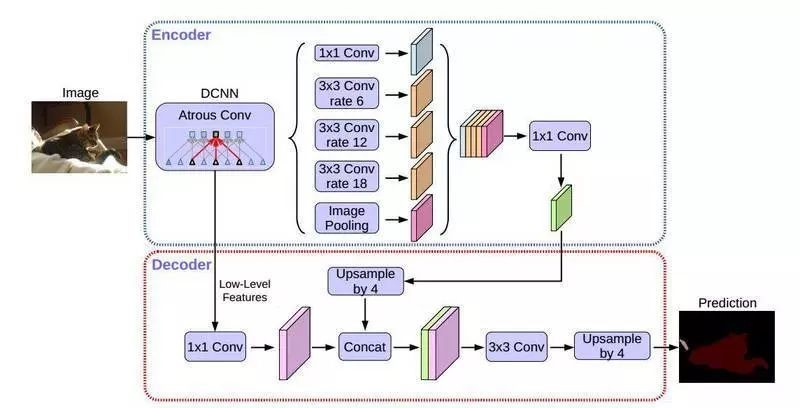

##### Build the DeepLab V3+ model

In [3]:
# get training and validation sample names
with open('/content/drive/My Drive/Road/train.txt',"r",encoding="utf-8") as f:
    train_base_fnames = [line.strip() for line in f]
with open('/content/drive/My Drive/Road/val.txt',"r",encoding="utf-8") as f:
    val_base_fnames = [line.strip() for line in f]
n_train, n_val = len(train_base_fnames), len(val_base_fnames)
batch_size = 5
steps_per_epoch = n_train // batch_size
steps_per_epoch_val = n_val // batch_size

# build model
model_deeplab = SemanticSegmentationModel(model_name='deeplab_v3p',
                  input_shape=(512,512,3),
                  n_class=2,
                  encoder_name='xception_41',
                  init_filters=64,
                  dropout=0.5,
                  weight_decay=1e-4)

plot_model(model_deeplab, "/content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5".replace(".h5", ".png"), show_shapes=True)
model_deeplab.summary()
model_deeplab.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print("training data size = %d" % n_train)
print("validation data size = %d" % n_val)
print("training iteration/epoch = %d" % steps_per_epoch)
print("validation iteration/epoch = %d" % steps_per_epoch_val)
print("model save path: %s" % "/content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5")


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
entry_block1_conv1 (Conv2D)     (None, 256, 256, 32) 864         batch_normalization[0][0]        
__________________________________________________________________________________________________
entry_block1_conv1_bn (BatchNor (None, 256, 256, 32) 128         entry_block1_conv1[0][0]         
_______________________________________________________________________________________

##### Training DeepLab V3+

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.2,
    horizontal_flip=True)
val_datagen = ImageDataGenerator()

callbacks = list()
callbacks.append(ModelCheckpoint("/content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5",save_best_only=True,save_weights_only=True,verbose=1))
callbacks.append(TensorBoard(log_dir=os.path.join('/content/drive/MyDrive/Road/Deeplabv3p', 'logs')))

hist_deeplab = model_deeplab.fit_generator(
    generator=train_datagen.flow_from_directory(
        base_fnames=train_base_fnames,
        image_dir='/content/drive/My Drive/Road/Train/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/My Drive/Road/Train/target_maps',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=True,
        dataset_name='Road'),
    validation_data=val_datagen.flow_from_directory(
        base_fnames=val_base_fnames,
        image_dir='/content/drive/My Drive/Road/Train/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/My Drive/Road/Train/input_images',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=False),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    epochs=50,
    callbacks=callbacks,
    verbose=1)

print("%s Training success!")

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.1615 - acc: 0.9654
Epoch 00001: val_loss improved from inf to 5.86529, saving model to /content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5
200/200 [==============================] - 250s 1s/step - loss: 0.1615 - acc: 0.9654 - val_loss: 5.8653 - val_acc: 0.0261
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1422 - acc: 0.9669
Epoch 00002: val_loss improved from 5.86529 to 3.85732, saving model to /content/drive/MyDrive/Road/Deeplabv3p/deeplabv3p.h5
200/200 [==============================] - 250s 1s/step - loss: 0.1422 - acc: 0.9669 - val_loss: 3.8573 - val_acc: 0.0572
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.1321 - acc: 0.9673
Epoch 00003: val_loss did not improve from 3.85732
200/200 [==============================] - 247s 1s/step - loss: 0.1321 - acc: 0.9673 - val_loss: 5.0710 - val_acc: 0.0347
Epoch 4/50
  7/200 [>.............................] - ETA: 3:34 

KeyboardInterrupt: ignored

##### Predict
To see how DeepLab V3+ works, I will use a minibatch of validation data and display 5 images and the prediction map of them.

In [ ]:
image_fnames = os.listdir(predicting_config.image_dir)
for image_fname in tqdm(image_fnames):
    src_fname = os.path.join(predicting_config.image_dir, image_fname)
    dst_fname = os.path.join(predicting_config.preds_dir, image_fname)
    pred = predict_per_image(model, src_fname, predicting_config.image_height, predicting_config.image_width,
                              predicting_config.to_prob, predicting_config.plot, predicting_config.dataset_name)
    

##### Evaluate

In [ ]:
preds_fnames = os.listdir(evaluating_config.preds_dir)
label_fnames = os.listdir(evaluating_config.label_dir)
n_class = len(NAME_MAP[evaluating_config.dataset_name])

if evaluating_config.mode == "global":
    mat = np.zeros((n_class, n_class))

    for preds_fname, label_fname in tqdm(zip(preds_fnames, label_fnames)):
        print(preds_fname, label_fname)
        preds = load_image(os.path.join(evaluating_config.preds_dir, preds_fname), is_gray=True)
        h, w, _ = preds.shape
        label = load_image(os.path.join(evaluating_config.label_dir, label_fname), is_gray=True, target_size=(h, w))
        _mat = confusion_matrix(label.reshape(-1), preds.reshape(-1), labels=np.arange(n_class))
        mat = mat + _mat
    if evaluating_config.ignore_0:
        mat = mat[1:, 1:]
    avg_metric = compute_global_metrics(mat)

elif evaluating_config.mode == "per_image":
    avg_metric = {"accuracies_per_class": np.zeros(n_class), "macro_accuracy": 0., "micro_accuracy": 0.,
      "precisions_per_class": np.zeros(n_class), "precision": 0.,
      "recalls_per_class": np.zeros(n_class), "recall": 0.,
      "f1s_pre_class": np.zeros(n_class), "f1": 0.,
      "ious_per_class": np.zeros(n_class), "miou": 0.}
    count = {"accuracies_per_class": np.zeros(n_class), "macro_accuracy": 0, "micro_accuracy": 0,
              "precisions_per_class": np.zeros(n_class), "precision": 0,
              "recalls_per_class": np.zeros(n_class), "recall": 0,
              "f1s_pre_class": np.zeros(n_class), "f1": 0,
              "ious_per_class": np.zeros(n_class), "miou": 0}
    for preds_fname, label_fname in zip(preds_fnames, label_fnames):
        preds = load_image(os.path.join(evaluating_config.preds_dir, preds_fname), is_gray=True)
        h, w, _ = preds.shape
        label = load_image(os.path.join(evaluating_config.label_dir, label_fname), is_gray=True, target_size=(h, w))

        metric = compute_metrics_per_image(label, preds, n_class)
        for key in metric:
            if not np.isscalar(metric[key]):
                for i in range(len(metric[key])):
                    if not np.isnan(metric[key][i]):
                        avg_metric[key][i] = avg_metric[key][i] + metric[key][i]
                        count[key][i] += 1
            else:
                avg_metric[key] = avg_metric[key] + metric[key]
                count[key] += 1

    for key in avg_metric:
        if not np.isscalar(avg_metric[key]):
            for i in range(len(avg_metric[key])):
                if not np.isnan(avg_metric[key][i]):
                    avg_metric[key][i] = avg_metric[key][i] / count[key][i]
        else:
            avg_metric[key] = avg_metric[key] / count[key]
else:
    raise ValueError("Invalid 'mode': %s. Expected to be 'global' or 'per_image'!" % evaluating_config.mode)

for key in avg_metric:
    print('{:^20s}{}'.format(key, avg_metric[key]))
return avg_metric

* Plot the training accuracy and validation accuracy curves on the same figure.  



### RefineNet

RefineNet is a general multi-path optimized network proposed in 2016. Since the current deep convolutional network has outstanding performance in target recognition and image segmentation, but frequent downsampling loses the information of the original image, RefineNet clearly uses all the information available in the entire downsampling process and uses remote residual connection Achieve high-resolution predictions. In this way, the fine-grained features in the early convolution can be used to directly refine the deeper network layers that capture high-level semantic features. The various components of RefineNet use residual connections that follow the idea of ​​identity mapping, which allows the network to perform effective end-to-end training.
RefineNet solves the problem of reduced spatial resolution in traditional convolutional networks, which is very different from the method used by PSPNet (which uses a high computational cost of convolution with holes). The proposed architecture iterative pooling feature uses a special RefineNet module to increase different resolutions, and finally generates a high-resolution segmentation map. Therefore, it is very suitable for the task of road extraction in this research. The down-sampling convolutional layer used in the RefineNet network in this research is ResNet V2, with 200 layers.  
The picture below shows the architecture of RefineNet:  

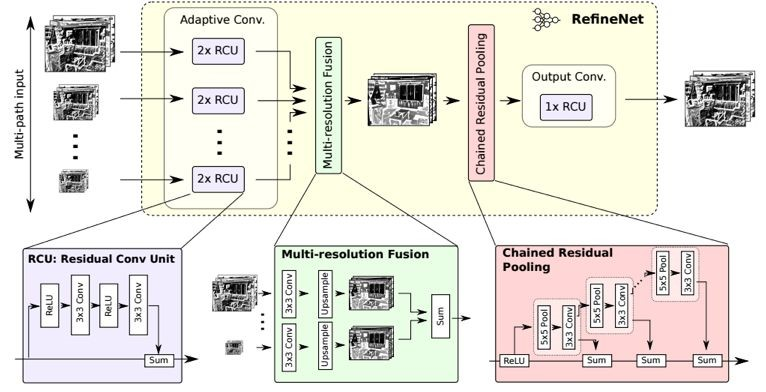

##### Build the RefineNet model

In [ ]:
model_refinenet = SemanticSegmentationModel(model_name='refinenet',
                  input_shape=(512,512,3),
                  n_class=2,
                  encoder_name='resnet_v2_101',
                  init_filters=64,
                  dropout=0.5,
                  weight_decay=1e-4)

plot_model(model_refinenet, "/content/drive/MyDrive/Road/Refinenet/refinenet.h5".replace(".h5",".png"), show_shapes=True)
model_refinenet.summary()
model_refinenet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print("training data size = %d" % n_train)
print("validation data size = %d" % n_val)
print("training iteration/epoch = %d" % steps_per_epoch)
print("validation iteration/epoch = %d" % steps_per_epoch_val)
print("model save path: %s" % "/content/drive/MyDrive/Road/Refinenet/refinenet.h5")

##### Training RefineNet

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
val_datagen = ImageDataGenerator()

callbacks = list()
callbacks.append(ModelCheckpoint("/content/drive/MyDrive/Road/Refinenet/refinenet.h5",save_best_only=True,save_weights_only=True,verbose=1))
callbacks.append(TensorBoard(log_dir=os.path.join('/content/drive/MyDrive/Road/Refinenet', 'logs')))

hist_refinenet = model_refinenet.fit_generator(
    generator=train_datagen.flow_from_directory(
        base_fnames=train_base_fnames,
        image_dir='/content/drive/My Drive/Road/Train/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/My Drive/Road/Train/target_maps',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=True,
        dataset_name='Road'),
    validation_data=val_datagen.flow_from_directory(
        base_fnames=val_base_fnames,
        image_dir='/content/drive/My Drive/Road/Train/input_images',
        image_suffix='.tif',
        image_color_mode='rgb',
        label_dir='/content/drive/My Drive/Road/Train/input_images',
        label_suffix='.tif',
        n_class=2,
        feed_onehot_label=True,
        cval=0,
        label_cval=0,
        crop_mode='none',
        target_size=(512,512),
        batch_size=batch_size,
        shuffle=False),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    epochs=10,
    callbacks=callbacks,
    verbose=1)

print("%s training success!")

##### Predict

### Comparison